In [184]:
import dask
import dask.dataframe as dd
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy as sp
from tsfresh.feature_extraction import feature_calculators
from scipy import signal
from scipy.signal import savgol_filter

import os
print(os.listdir("./"))
from detect_peaks import detect_peaks
#150_000 is the number of the sample of each test, so is make up of appproximatly 36 steps of signals
seg_len = 150000
n_factor = 3
normalize_frec = 448800
n_spliting_seg = 50
min_threshold = 0.05  #to avoid the noisy segments of the signal

['train.csv', 'First_attempt.ipynb', 'Untitled.ipynb', '.ipynb_checkpoints', 'sample_submission.csv', 'TestFeatures.ipynb', 'DataSplitingAndAnalysis.ipynb', 'detect_peaks.py', 'JoinAll.py', '__pycache__', 'test', 'detect_peaks_1.py', 'Analisis PSD.ipynb']


In [206]:
# This funtion calculate all features related with the PSD analisys. Just the 3 main maximun and the three respective 
#positions. Without sorting. Return a np.array of len(n_spliting_seg)*6. 
def features_psd(signal_seg):
    n_features_psd = 6
    index_list = index_list_of_segment(n_spliting_seg)
    n_spliting_tot = len(index_list)
    features_PSD = np.zeros(n_features_psd*n_spliting_tot)
    count = 0
    for ini, fini in index_list:
        _frequencies, power_spectrum = get_segment_spectrum(signal_seg[ini:fini])
        index_max = np.argmax(power_spectrum) 

        #print(feature_calculators.first_location_of_maximum(power_spectrum))
        #print('mean:', np.mean(power_spectrum))

        result = savgol_filter(power_spectrum, 5, 2)

        if max(result[index_sort_1]) >= min_threshold:
            ind = detect_peaks(result,mpd=2, show=False)
            ind = ind[np.argsort(result[ind])[-3:]]
            features_PSD[count*n_features_psd:count*n_features_psd +3] = _frequencies[index_sort]/normalize_frec
            features_PSD[count*n_features_psd +3:count*n_features_psd +6] = result[index_sort]
        count += 1
        
    return features_PSD

#This function return a list of index that takes account a delay(step_len) in the data, 
#len_total, is the data length, n_factor is inversly proportional to the step_len. IS given by how much we split the data.
def index_list_of_data_seg(len_total,n_factor = 3, seg_len = 150000):
    step_len = int(seg_len/n_factor)
    index_main = np.arange(0,len_total+1,step_len)
    index_list = []
    for i in np.arange(len(index_main)-n_factor):
        ini = index_main[i]
        fini = index_main[i+n_factor]
        index_list.append(np.array([ini,fini],dtype =int))        
    return index_list


#This function return a list of index that takes account the mixture of segments, holding the same len on each 'segment of segment'.
def index_list_of_segment(num_part,len_seg = 150000):
    print('Computing list of array index (ini:fin), to spliting (on rigth way) the segment data')
    index_list = []
    len_part = int(len_seg/num_part)           #Length of partition
    idx_main = np.arange(0,len_seg+1,int(len_seg/num_part)) 
    for i in np.arange(len(idx_main)-1):
        ind_both = np.array( [idx_main[i],idx_main[i+1]],dtype='int')  
        index_list.append(ind_both)
        if i != len(idx_main)-2:
            ind_both = np.array( [idx_main[i+1]-int(len_part/2),idx_main[i+1]+int(len_part/2)],dtype='int')  
            index_list.append(ind_both)
    return index_list
#Definition of functions, to get the common features, and related to the spectrum shape.

sampling_frequency = 4e6

def get_spectrum(input_signal):
    """
    Get a pandas Series with the fourier power spectum for a given signal segment.
    """
    input_signal = np.asarray(input_signal.values, dtype='float64')
    
    # Remove the mean  
    input_signal -= input_signal.mean()  
    
    #Cleaning the signal noyse
    input_signal = savgol_filter(input_signal, 15, 2)
    
    
    # Estimate power spectral density using a periodogram.
    frequencies , power_spectrum = signal.periodogram(input_signal, sampling_frequency, scaling='spectrum')    
    
    # Run a running windows average of 10-points to smooth the signal.
    power_spectrum = pd.Series(power_spectrum, index=frequencies).rolling(window=10).mean()        
    
    return pd.Series(power_spectrum)

def get_segment_spectrum(segment_df):
    """
    Get the fourier power spectrum of a given segment.
    
    Returns the quake_time, frequencies, and power_spectrum
    """
    
    #quake_time =segment_df['time_to_failure'].values[-1]
    
    _power_spectrum = get_spectrum(segment_df['acoustic_data']).dropna() 
    
    # Keep only frequencies < 450khz (larger frequencies have a negligible contribution).
    _power_spectrum = _power_spectrum[_power_spectrum.index<450_000]
    
    # Keep one every 10 samples
    power_spectrum=_power_spectrum.values[::5]
    frequencies=_power_spectrum.index.values[::5]    
    
    return frequencies, power_spectrum


In [13]:
%%time
reader = pd.read_csv("./train.csv", dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}, iterator=True)
number_load_data = seg_len*500
#Flag to finish the while in all the file
flag_done_load = 1 

CPU times: user 0 ns, sys: 3.78 ms, total: 3.78 ms
Wall time: 8.11 ms


In [14]:
data_left = pd.DataFrame({})
total_num_segm_to_treat = 0
index_to_pd = 0
target_values =  np.array([],dtype = int)
features_list = []

while flag_done_load:
    print('entro \n')
    
    data = reader.get_chunk(number_load_data)
    len_total = len(data)
    print('It is taken a data of len: ',len_total)
    
    #assert(len(data) == number_load_data)
    if len_total != number_load_data:
        print('Seems, the loading data, it is done.')
        flag_done_load = 0
    
    
    # after first cycle, we concatenate the left data in before loop-wise with the upload data from file
   
    data = pd.concat([data_left,data])
    len_total = len(data)
    #looking for index of cycles
    index_list_data = index_list_of_data_seg(len_total,n_factor)
    
    ini_back_up = 0
    for ini, fini in index_list_data:           
        total_num_segm_to_treat += 1
        index_to_pd = np.append(index_to_pd,total_num_segm_to_treat)
        signal_seg = data[:][ini:fini]
        target_values = np.append(target_values,signal_seg.time_to_failure.values[-1:], axis=0)
        #target_values = signal_seg.time_to_failure.values[-1:]
        ini_back_up = ini
        
    step_len = int(seg_len/n_factor)
    data_left = data[:][ini_back_up+step_len:]
    print('Saving data left, at last loop-wise, data_left of len: ', len(data_left), 'from index', ini_back_up+step_len)
            
    
print('Total number of segments:', total_num_segm_to_treat)
    

entro 

It is taken a data of len:  75000000
Saving data left, at last loop-wise, data_left of len:  100000 from index 74900000
entro 

It is taken a data of len:  75000000
Saving data left, at last loop-wise, data_left of len:  100000 from index 75000000
entro 

It is taken a data of len:  75000000
Saving data left, at last loop-wise, data_left of len:  100000 from index 75000000
entro 

It is taken a data of len:  75000000
Saving data left, at last loop-wise, data_left of len:  100000 from index 75000000
entro 

It is taken a data of len:  75000000
Saving data left, at last loop-wise, data_left of len:  100000 from index 75000000
entro 

It is taken a data of len:  75000000
Saving data left, at last loop-wise, data_left of len:  100000 from index 75000000
entro 

It is taken a data of len:  75000000
Saving data left, at last loop-wise, data_left of len:  100000 from index 75000000
entro 

It is taken a data of len:  75000000
Saving data left, at last loop-wise, data_left of len:  100

In [269]:
def features(signal):
    #signal_pros = signal['acoustic_data'].values
    feature_dict = {}
       
    psd_features = features_psd(signal)
    string_PSD = 'PSD_'
    for i in np.arange(len(psd_features)):
        feature_dict[string_PSD+str(i)] = psd_features[i]

    return feature_dict

In [270]:
A = np.array([])

print(A, A.shape)

A = np.append(A,signal_seg.time_to_failure.values[-1:], axis = 0)
print(A)
A = np.append(A,signal_seg.time_to_failure.values[-1:], axis = 0)
print(A, A.shape)


A = np.array([])

A = np.append(A,signal_seg.time_to_failure.values[-1:])
print(A)
A = np.append(A,signal_seg.time_to_failure.values[-1:])
print(A, A.shape)

[] (0,)
[9.77149582]
[9.77149582 9.77149582] (2,)
[9.77149582]
[9.77149582 9.77149582] (2,)


In [271]:

print(features(signal_seg).values)

Computing list of array index (ini:fin), to spliting (on rigth way) the segment data
<built-in method values of dict object at 0x7f2733826ab0>


In [24]:
string_1 = 'algo_'
print(string_1+str(1))

algo_1


Computing list of array index (ini:fin), to spliting (on rigth way) the segment data
0.5454545454545454
mean: 0.04205563819532356
Maximun:  0.17403805172550338


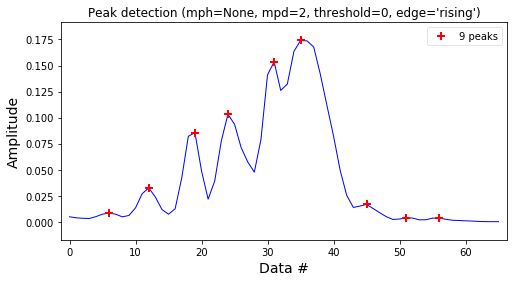

[0.38324421 0.48722519 0.5466429 ]
[0.10313224 0.15351525 0.17403805]
[0.10313224 0.15351525 0.17403805]
0.17403805172550338
0.5151515151515151
mean: 0.02069729362990264
Maximun:  0.09261470411467512


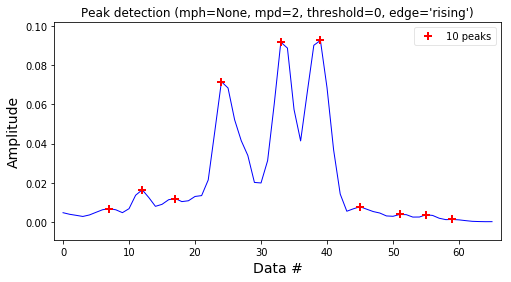

[0.38324421 0.51693405 0.60606061]
[0.07157791 0.09173969 0.0926147 ]
[0.07157791 0.09173969 0.0926147 ]
0.09261470411467512
0.5757575757575758
mean: 0.005739331830474914
Maximun:  0.013698362385934332


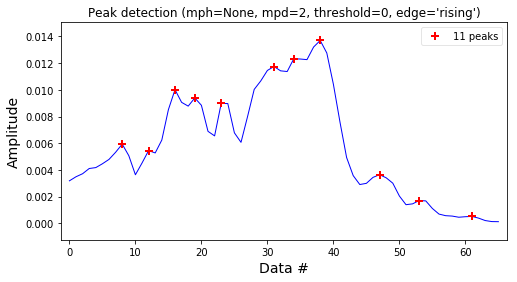

[0.48722519 0.53178847 0.59120618]
[0.01174858 0.01233129 0.01369836]
[0.01174858 0.01233129 0.01369836]
0.013698362385934332
0.3484848484848485
mean: 0.004546833367062715
Maximun:  0.01239678584521054


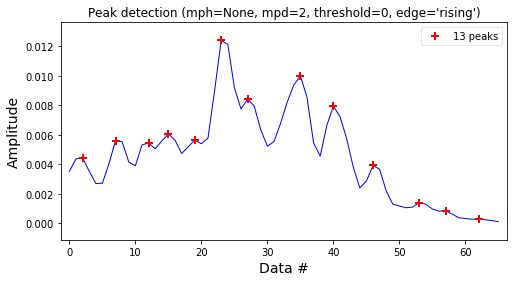

[0.36838978 0.42780749 0.5466429 ]
[0.01239679 0.00841876 0.00998987]
[0.00841876 0.00998987 0.01239679]
0.01239678584521054
0.2878787878787879
mean: 0.0045724395327119615
Maximun:  0.013302113823470754


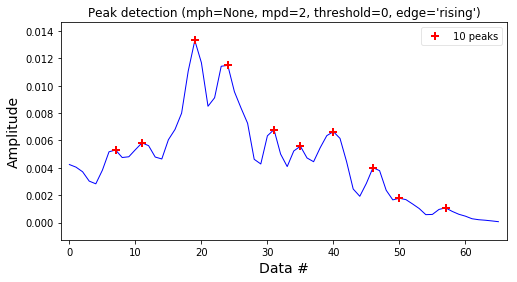

[0.30897207 0.38324421 0.48722519]
[0.01330211 0.01148474 0.0067941 ]
[0.0067941  0.01148474 0.01330211]
0.013302113823470754
0.2878787878787879
mean: 0.005431769688675653
Maximun:  0.013158325346791146


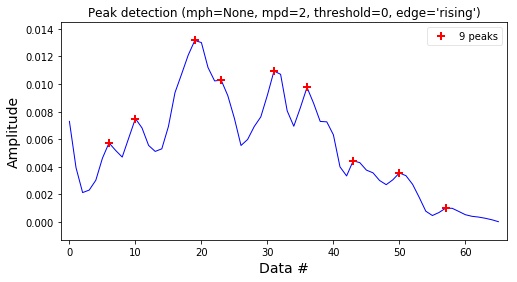

[0.30897207 0.36838978 0.48722519]
[0.01315833 0.01028221 0.01094729]
[0.01028221 0.01094729 0.01315833]
0.013158325346791146
0.4393939393939394
mean: 0.005191691897136322
Maximun:  0.012910948828216067


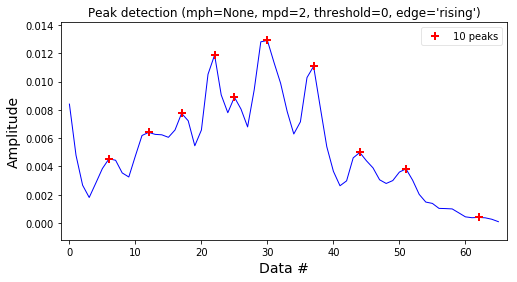

[0.35353535 0.47237077 0.57635175]
[0.01188299 0.01291095 0.01108384]
[0.01108384 0.01188299 0.01291095]
0.012910948828216067
0.4393939393939394
mean: 0.00479381424640599
Maximun:  0.012457144351371892


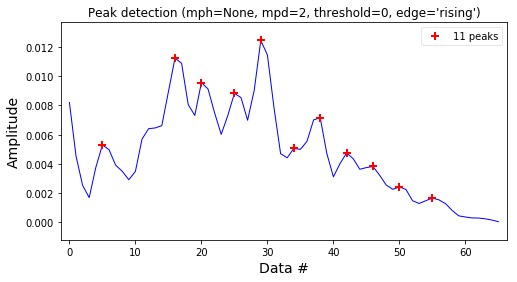

[0.26440879 0.3238265  0.45751634]
[0.01125074 0.0095662  0.01245714]
[0.0095662  0.01125074 0.01245714]
0.012457144351371892
0.25757575757575757
mean: 0.004807834511356248
Maximun:  0.013250443844424505


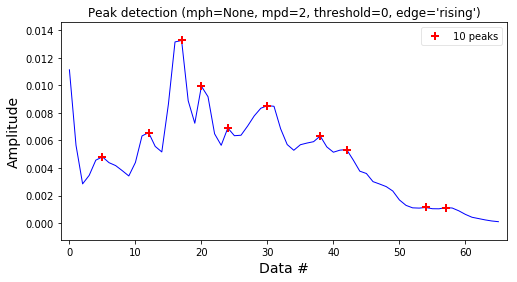

[0.27926322 0.3238265  0.47237077]
[0.01325044 0.00993137 0.00852258]
[0.00852258 0.00993137 0.01325044]
0.013250443844424505
0.2727272727272727
mean: 0.00577060165583067
Maximun:  0.015288958710747043


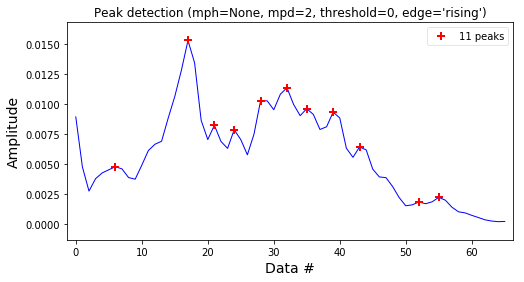

[0.27926322 0.44266191 0.50207962]
[0.01528896 0.01026701 0.01135149]
[0.01026701 0.01135149 0.01528896]
0.015288958710747043
0.22727272727272727
mean: 0.006046659933612636
Maximun:  0.012701517259727776


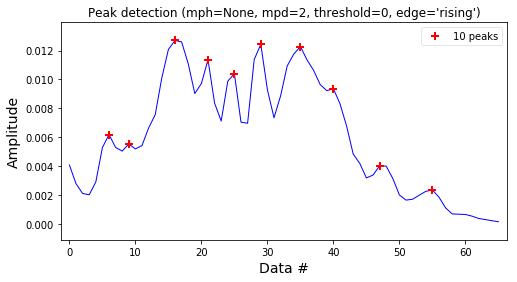

[0.26440879 0.45751634 0.5466429 ]
[0.01270152 0.01243907 0.0122791 ]
[0.0122791  0.01243907 0.01270152]
0.012701517259727776
0.5606060606060606
mean: 0.006002728797144858
Maximun:  0.015508983052230469


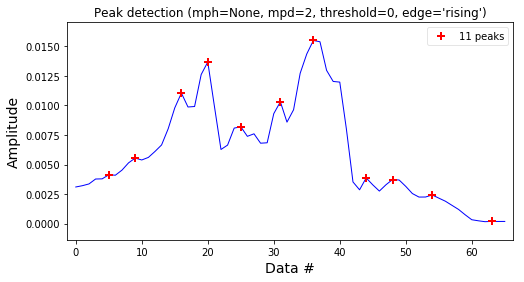

[0.26440879 0.3238265  0.56149733]
[0.01105478 0.01368526 0.01550898]
[0.01105478 0.01368526 0.01550898]
0.015508983052230469
0.45454545454545453
mean: 0.006688919629934682
Maximun:  0.01680000177507459


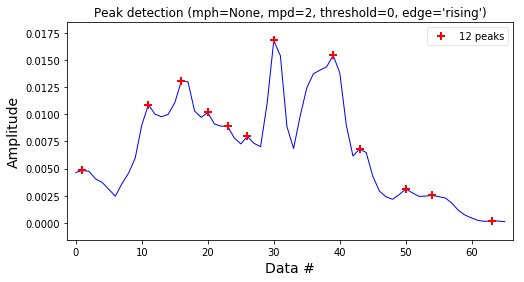

[0.26440879 0.47237077 0.60606061]
[0.01305695 0.0168     0.01542833]
[0.01305695 0.01542833 0.0168    ]
0.01680000177507459
0.45454545454545453
mean: 0.0055121167034975814
Maximun:  0.012326855698666185


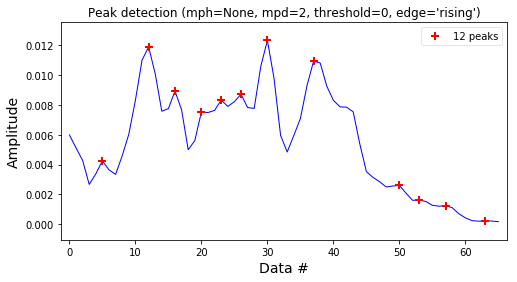

[0.20499109 0.47237077 0.57635175]
[0.01189815 0.01232686 0.01094291]
[0.01094291 0.01189815 0.01232686]
0.012326855698666185
0.45454545454545453
mean: 0.004441657871151959
Maximun:  0.011503527493525612


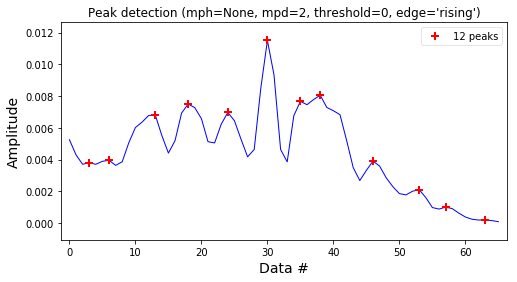

[0.47237077 0.5466429  0.59120618]
[0.01150353 0.0076637  0.00805833]
[0.0076637  0.00805833 0.01150353]
0.011503527493525612
0.3333333333333333
mean: 0.005419746209497232
Maximun:  0.0147093556379576


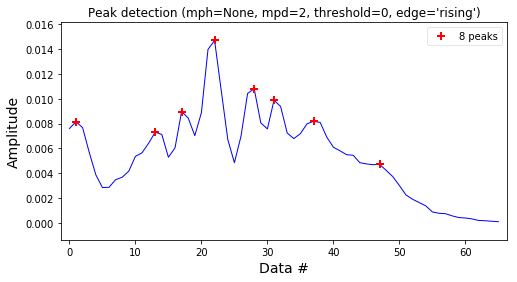

[0.35353535 0.44266191 0.48722519]
[0.01470936 0.01081249 0.00988344]
[0.00988344 0.01081249 0.01470936]
0.0147093556379576
0.3181818181818182
mean: 0.005682130239350894
Maximun:  0.01364476348486627


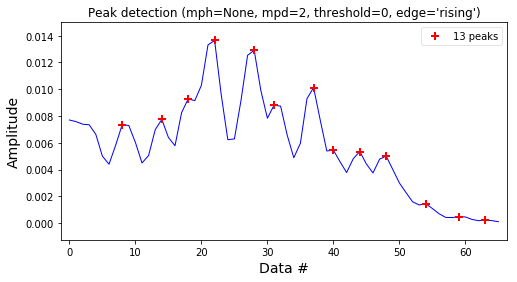

[0.35353535 0.44266191 0.57635175]
[0.01364476 0.01291452 0.0101252 ]
[0.0101252  0.01291452 0.01364476]
0.01364476348486627
0.4696969696969697
mean: 0.004596699011956874
Maximun:  0.009640392936274177


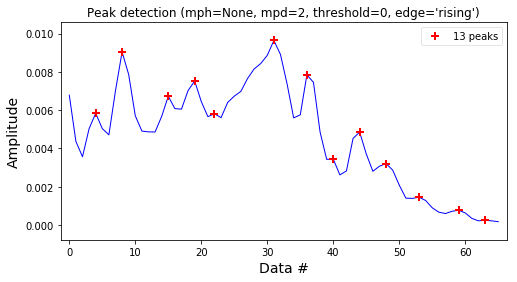

[0.14557338 0.48722519 0.56149733]
[0.009044   0.00964039 0.00784054]
[0.00784054 0.009044   0.00964039]
0.009640392936274177
0.18181818181818182
mean: 0.0048996529877886105
Maximun:  0.011875897279977158


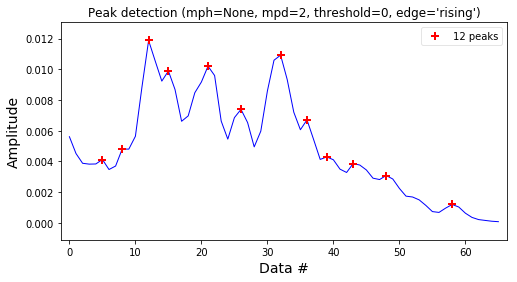

[0.20499109 0.33868093 0.50207962]
[0.0118759  0.01020209 0.01092062]
[0.01020209 0.01092062 0.0118759 ]
0.011875897279977158
0.5606060606060606
mean: 0.008073739462172158
Maximun:  0.04056494908544652


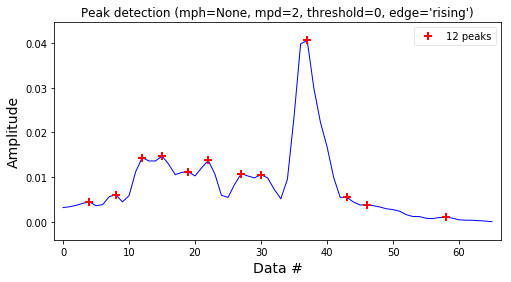

[0.20499109 0.24955437 0.57635175]
[0.01439793 0.01473378 0.04056495]
[0.01439793 0.01473378 0.04056495]
0.04056494908544652
0.5606060606060606
mean: 0.008096673597635226
Maximun:  0.041878019961231916


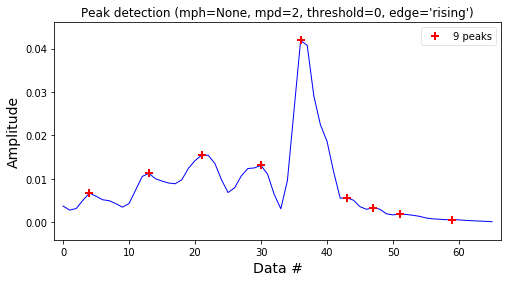

[0.33868093 0.47237077 0.56149733]
[0.01542991 0.01307432 0.04187802]
[0.01307432 0.01542991 0.04187802]
0.041878019961231916
0.3484848484848485
mean: 0.005297256039059422
Maximun:  0.014558635702325379


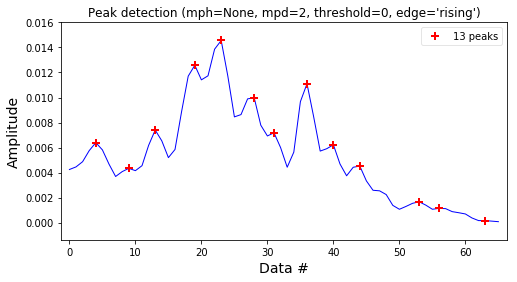

[0.30897207 0.36838978 0.56149733]
[0.01257953 0.01455864 0.01110149]
[0.01110149 0.01257953 0.01455864]
0.014558635702325379
0.5606060606060606
mean: 0.005077825156539221
Maximun:  0.012171342239980999


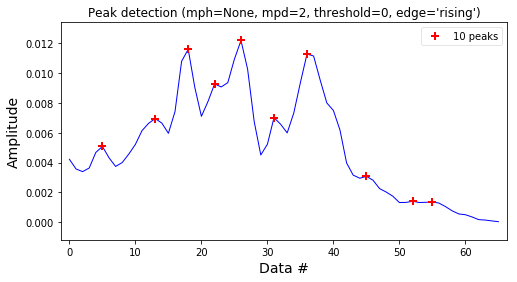

[0.29411765 0.41295306 0.56149733]
[0.01157873 0.01217134 0.01126535]
[0.01126535 0.01157873 0.01217134]
0.012171342239980999
0.3787878787878788
mean: 0.005200437421475181
Maximun:  0.011217705686488916


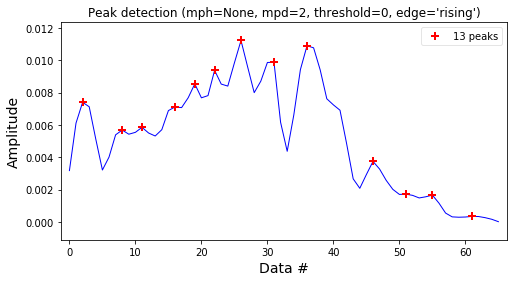

[0.41295306 0.48722519 0.56149733]
[0.01121771 0.00986735 0.01088856]
[0.00986735 0.01088856 0.01121771]
0.011217705686488916
0.42424242424242425
mean: 0.004803041887877865
Maximun:  0.010709437409028827


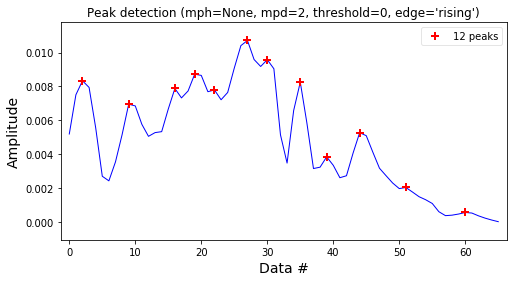

[0.30897207 0.42780749 0.47237077]
[0.00872388 0.01070944 0.00957803]
[0.00872388 0.00957803 0.01070944]
0.010709437409028827
0.2878787878787879
mean: 0.004284140335250006
Maximun:  0.00920786028070367


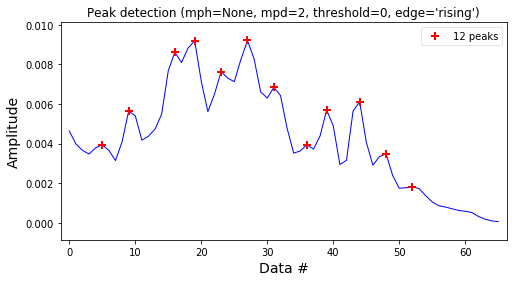

[0.26440879 0.30897207 0.42780749]
[0.00861897 0.00919397 0.00920786]
[0.00861897 0.00919397 0.00920786]
0.00920786028070367
0.25757575757575757
mean: 0.004539291234835558
Maximun:  0.011622428171977093


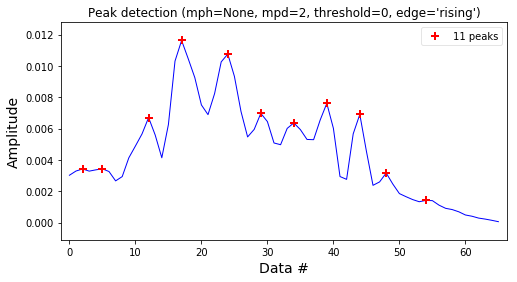

[0.27926322 0.38324421 0.60606061]
[0.01162243 0.01075455 0.00761078]
[0.00761078 0.01075455 0.01162243]
0.011622428171977093
0.2727272727272727
mean: 0.0059270958954200734
Maximun:  0.015819401253199437


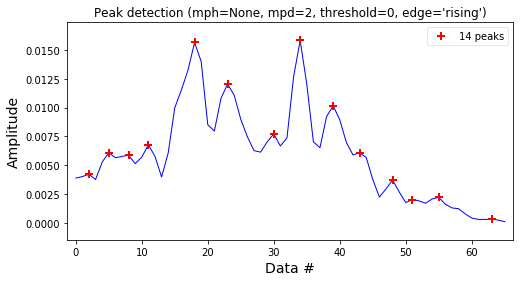

[0.29411765 0.36838978 0.53178847]
[0.01565011 0.01203818 0.0158194 ]
[0.01203818 0.01565011 0.0158194 ]
0.015819401253199437
0.3333333333333333
mean: 0.00619544821392834
Maximun:  0.014905496357486853


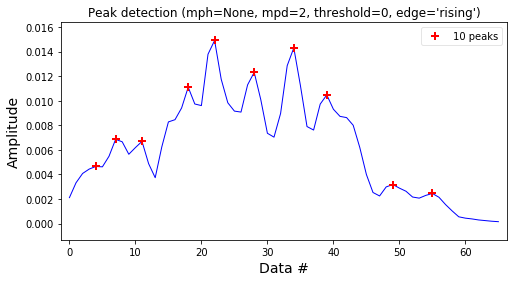

[0.35353535 0.44266191 0.53178847]
[0.0149055  0.01231299 0.0143037 ]
[0.01231299 0.0143037  0.0149055 ]
0.014905496357486853
0.45454545454545453
mean: 0.005743180274649042
Maximun:  0.01738358317086677


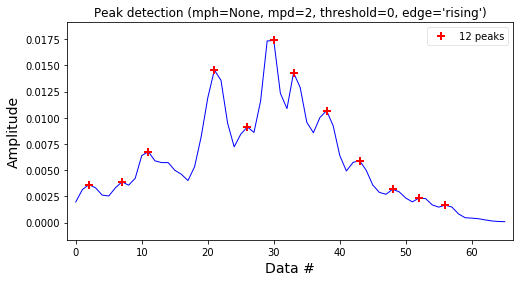

[0.33868093 0.47237077 0.51693405]
[0.01456454 0.01738358 0.01430625]
[0.01430625 0.01456454 0.01738358]
0.01738358317086677
0.45454545454545453
mean: 0.005586679709677508
Maximun:  0.014816612793470102


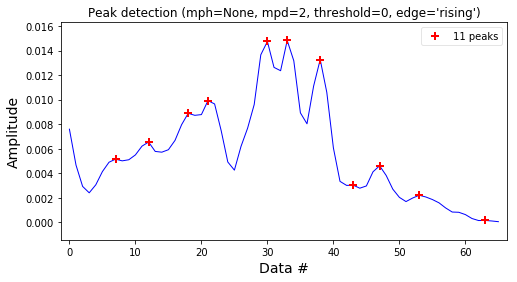

[0.47237077 0.51693405 0.59120618]
[0.0147371  0.01481661 0.01326428]
[0.01326428 0.0147371  0.01481661]
0.014816612793470102
0.4090909090909091
mean: 0.005689223954743166
Maximun:  0.01192510619360856


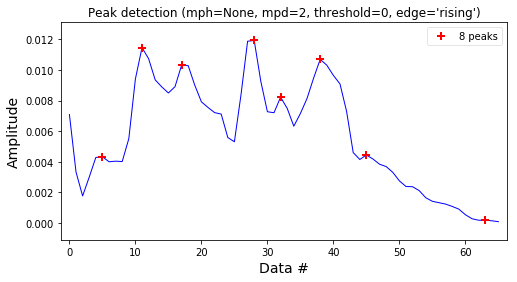

[0.19013666 0.44266191 0.59120618]
[0.01146297 0.01192511 0.01069226]
[0.01069226 0.01146297 0.01192511]
0.01192510619360856
0.4090909090909091
mean: 0.005486035989476253
Maximun:  0.012129699563696509


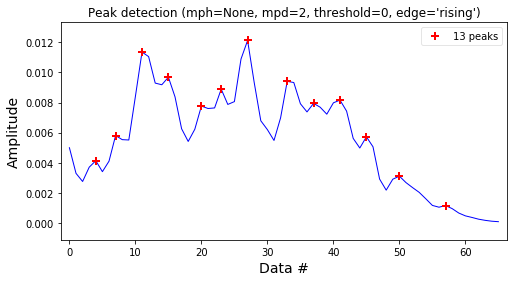

[0.19013666 0.24955437 0.42780749]
[0.01135977 0.00968732 0.0121297 ]
[0.00968732 0.01135977 0.0121297 ]
0.012129699563696509
0.5151515151515151
mean: 0.004527403203286184
Maximun:  0.00950223638685404


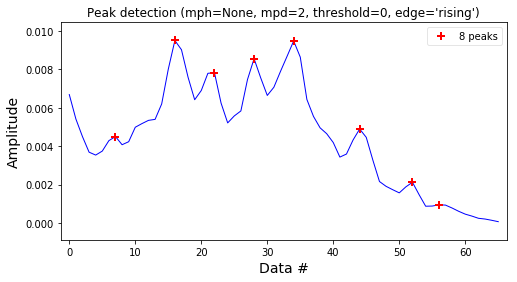

[0.26440879 0.44266191 0.53178847]
[0.00950224 0.00855332 0.00947756]
[0.00855332 0.00947756 0.00950224]
0.00950223638685404
0.5909090909090909
mean: 0.05158939977207856
Maximun:  0.5067427756351897


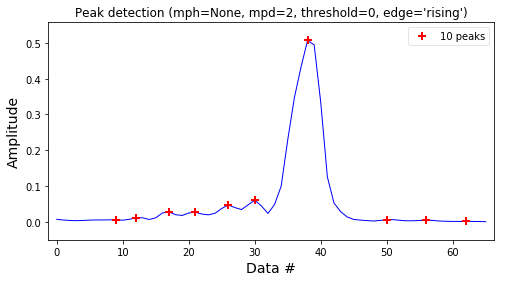

[0.41295306 0.47237077 0.59120618]
[0.04690916 0.05995949 0.50674278]
[0.04690916 0.05995949 0.50674278]
0.5067427756351897
0.5909090909090909
mean: 0.05636757156136467
Maximun:  0.49719213107913474


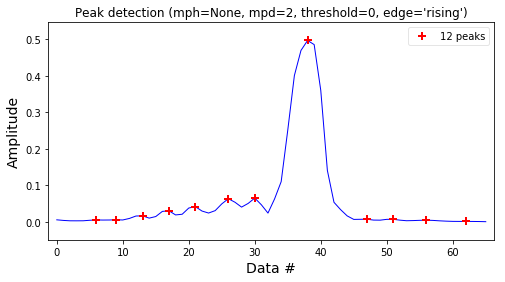

[0.41295306 0.47237077 0.59120618]
[0.06324305 0.06495003 0.49719213]
[0.06324305 0.06495003 0.49719213]
0.49719213107913474
0.5454545454545454
mean: 0.011148364817187928
Maximun:  0.06385351768421252


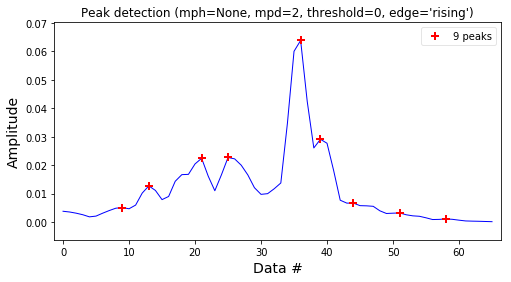

[0.39809863 0.56149733 0.60606061]
[0.02270517 0.06385352 0.02910198]
[0.02270517 0.02910198 0.06385352]
0.06385351768421252
0.5606060606060606
mean: 0.013711819764430744
Maximun:  0.09273235278943182


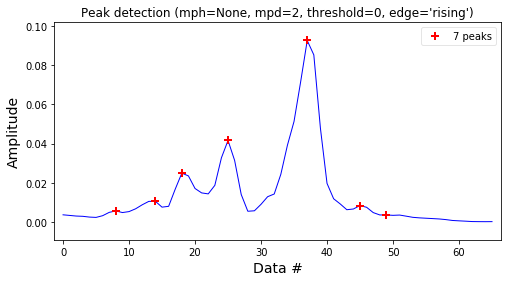

[0.29411765 0.39809863 0.57635175]
[0.02490992 0.04160371 0.09273235]
[0.02490992 0.04160371 0.09273235]
0.09273235278943182
0.5606060606060606
mean: 0.0126144802228385
Maximun:  0.07710666488175157


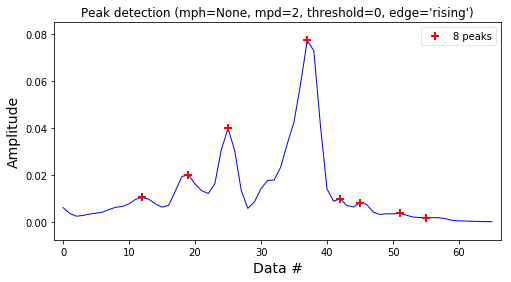

[0.30897207 0.39809863 0.57635175]
[0.02005476 0.03969309 0.07710666]
[0.02005476 0.03969309 0.07710666]
0.07710666488175157
0.3787878787878788
mean: 0.008914515478926997
Maximun:  0.04055198972866439


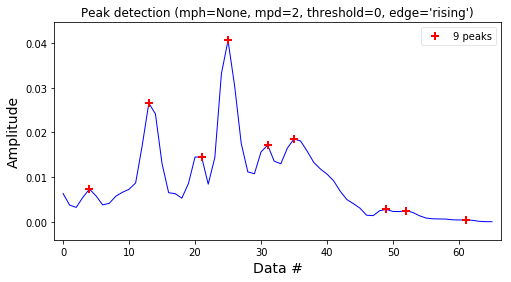

[0.21984551 0.39809863 0.5466429 ]
[0.02657032 0.04055199 0.01855702]
[0.01855702 0.02657032 0.04055199]
0.04055198972866439
0.3787878787878788
mean: 0.010002077378267936
Maximun:  0.04430417226357518


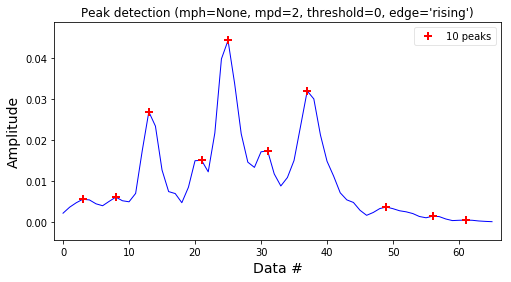

[0.21984551 0.39809863 0.57635175]
[0.02690016 0.04430417 0.0319821 ]
[0.02690016 0.0319821  0.04430417]
0.04430417226357518
0.5151515151515151
mean: 0.009776519675242838
Maximun:  0.035092823980975726


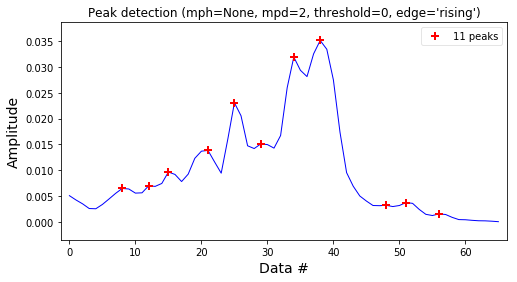

[0.39809863 0.53178847 0.59120618]
[0.02306279 0.03189123 0.03509282]
[0.02306279 0.03189123 0.03509282]
0.035092823980975726
0.5151515151515151
mean: 0.022291610366406544
Maximun:  0.09041293910363069


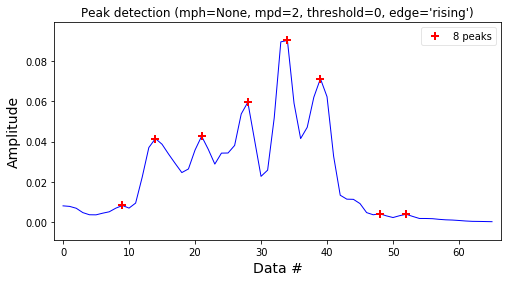

[0.44266191 0.53178847 0.60606061]
[0.05962721 0.09041294 0.07136381]
[0.05962721 0.07136381 0.09041294]
0.09041293910363069
0.5151515151515151
mean: 0.023786340921431413
Maximun:  0.09256074586738622


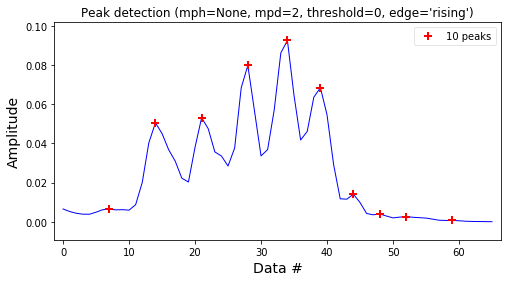

[0.44266191 0.53178847 0.60606061]
[0.07984688 0.09256075 0.06847023]
[0.06847023 0.07984688 0.09256075]
0.09256074586738622
0.5303030303030303
mean: 0.013066286057562118
Maximun:  0.07595539930270853


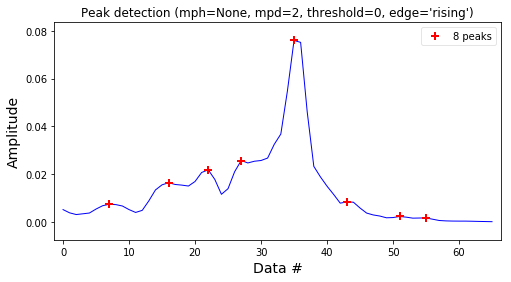

[0.35353535 0.42780749 0.5466429 ]
[0.0217976  0.02568687 0.0759554 ]
[0.0217976  0.02568687 0.0759554 ]
0.07595539930270853
0.5454545454545454
mean: 0.008548953225457508
Maximun:  0.05209412849958589


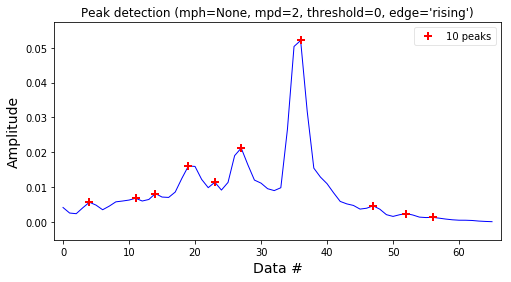

[0.30897207 0.42780749 0.56149733]
[0.01605375 0.02119576 0.05209413]
[0.01605375 0.02119576 0.05209413]
0.05209412849958589
0.5454545454545454
mean: 0.005915671812196797
Maximun:  0.016166705123059833


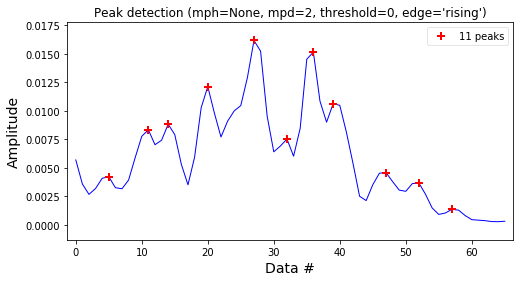

[0.3238265  0.42780749 0.56149733]
[0.01212386 0.01616671 0.01514667]
[0.01212386 0.01514667 0.01616671]
0.016166705123059833
0.5454545454545454
mean: 0.005587869328329908
Maximun:  0.017266998793222223


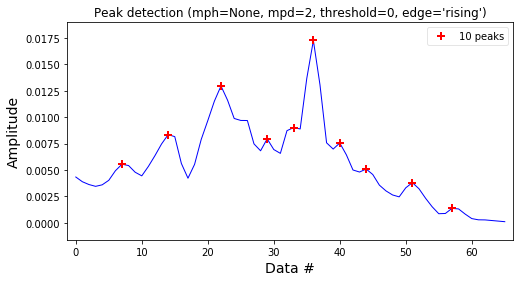

[0.35353535 0.51693405 0.56149733]
[0.0129575  0.00901224 0.017267  ]
[0.00901224 0.0129575  0.017267  ]
0.017266998793222223
0.5454545454545454
mean: 0.022203628082414505
Maximun:  0.22348397828435887


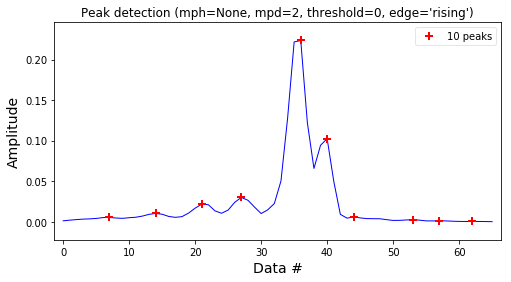

[0.42780749 0.56149733 0.62091503]
[0.02998063 0.22348398 0.10243688]
[0.02998063 0.10243688 0.22348398]
0.22348397828435887
0.5454545454545454
mean: 0.022669906684340647
Maximun:  0.22736490681880878


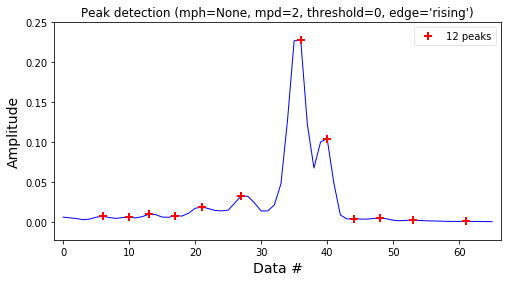

[0.42780749 0.56149733 0.62091503]
[0.03263977 0.22736491 0.10427018]
[0.03263977 0.10427018 0.22736491]
0.22736490681880878
0.4393939393939394
mean: 0.005452894816610831
Maximun:  0.01310902189576579


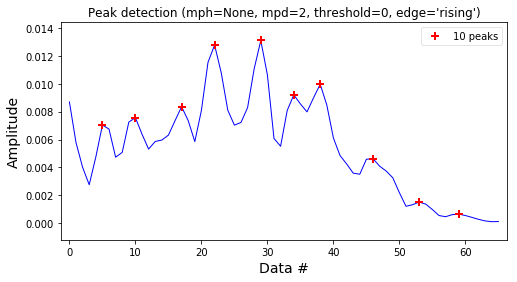

[0.35353535 0.45751634 0.59120618]
[0.01278086 0.01310902 0.00996383]
[0.00996383 0.01278086 0.01310902]
0.01310902189576579
0.45454545454545453
mean: 0.005289325855858838
Maximun:  0.012847969645996753


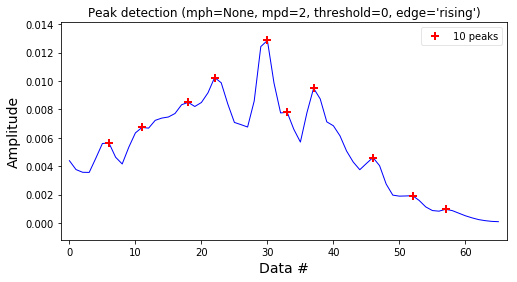

[0.35353535 0.47237077 0.57635175]
[0.01023769 0.01284797 0.00948658]
[0.00948658 0.01023769 0.01284797]
0.012847969645996753
0.45454545454545453
mean: 0.00521209295288263
Maximun:  0.012697487709004624


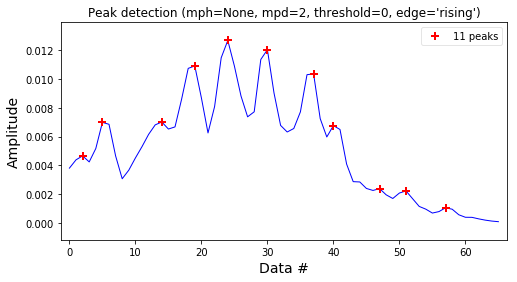

[0.30897207 0.38324421 0.47237077]
[0.01092387 0.01269749 0.01205784]
[0.01092387 0.01205784 0.01269749]
0.012697487709004624
0.3484848484848485
mean: 0.005053094511505349
Maximun:  0.012719818708099202


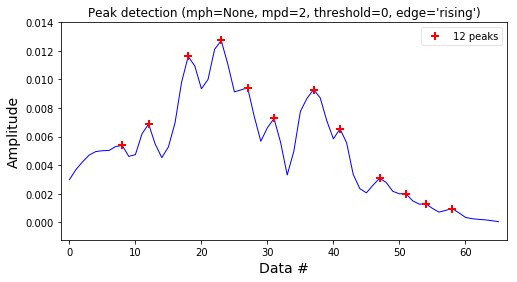

[0.29411765 0.36838978 0.42780749]
[0.01160439 0.01271982 0.00941589]
[0.00941589 0.01160439 0.01271982]
0.012719818708099202
0.5757575757575758
mean: 0.014756122599654224
Maximun:  0.08601935199095334


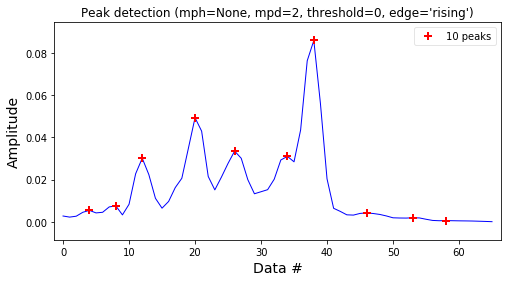

[0.3238265  0.41295306 0.59120618]
[0.04936683 0.03354208 0.08601935]
[0.03354208 0.04936683 0.08601935]
0.08601935199095334
0.5757575757575758
mean: 0.015178402607964164
Maximun:  0.08221297519154991


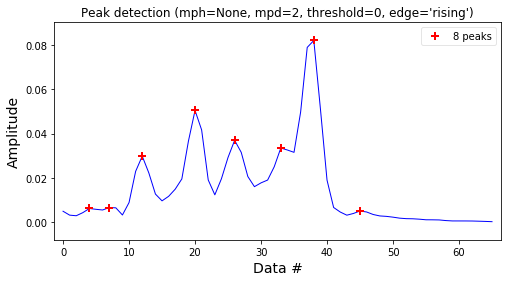

[0.3238265  0.41295306 0.59120618]
[0.05048681 0.03694282 0.08221298]
[0.03694282 0.05048681 0.08221298]
0.08221297519154991
0.30303030303030304
mean: 0.005261257859773025
Maximun:  0.016509619976417776


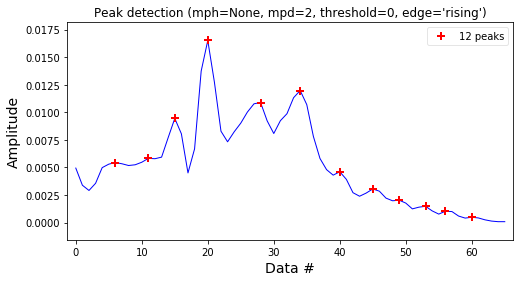

[0.3238265  0.44266191 0.53178847]
[0.01650962 0.01088845 0.0119736 ]
[0.01088845 0.0119736  0.01650962]
0.016509619976417776
0.30303030303030304
mean: 0.005502657884597058
Maximun:  0.013506055473772966


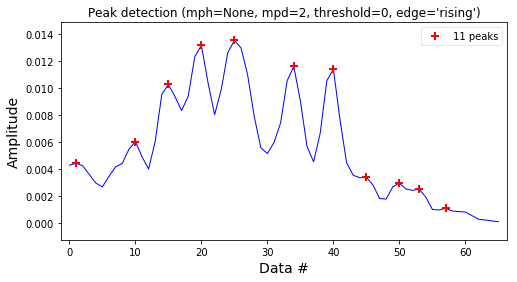

[0.3238265  0.39809863 0.53178847]
[0.01314306 0.01350606 0.01158288]
[0.01158288 0.01314306 0.01350606]
0.013506055473772966
0.3939393939393939
mean: 0.005418602917710134
Maximun:  0.013869687703143257


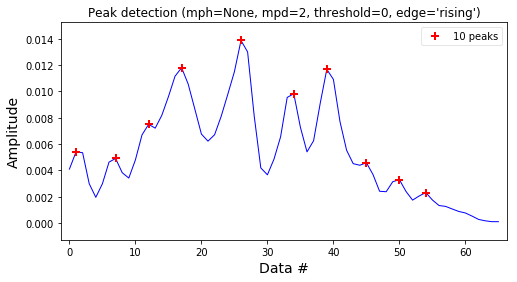

[0.27926322 0.41295306 0.60606061]
[0.01180124 0.01386969 0.01167617]
[0.01167617 0.01180124 0.01386969]
0.013869687703143257
0.25757575757575757
mean: 0.004956830130512471
Maximun:  0.011614135874864023


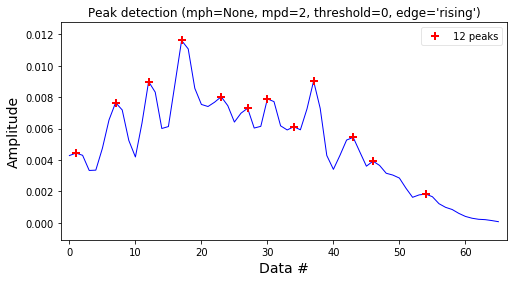

[0.20499109 0.27926322 0.57635175]
[0.00899374 0.01161414 0.00903198]
[0.00899374 0.00903198 0.01161414]
0.011614135874864023
0.3333333333333333
mean: 0.005216574205907442
Maximun:  0.013756983501844178


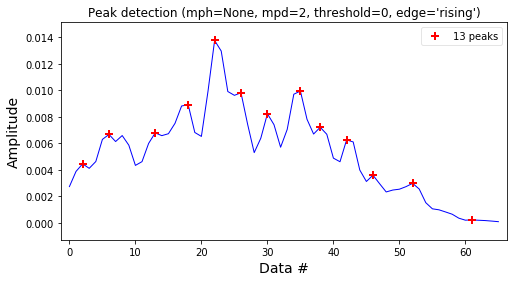

[0.35353535 0.41295306 0.5466429 ]
[0.01375698 0.00981335 0.00994558]
[0.00981335 0.00994558 0.01375698]
0.013756983501844178
0.3333333333333333
mean: 0.00576255898153732
Maximun:  0.01230355147630951


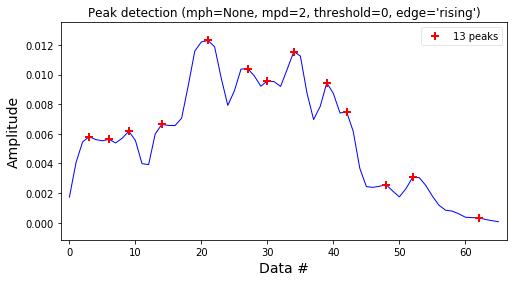

[0.33868093 0.42780749 0.53178847]
[0.01230355 0.01040915 0.01155548]
[0.01040915 0.01155548 0.01230355]
0.01230355147630951
0.5757575757575758
mean: 0.017053544246951973
Maximun:  0.14523863448032223


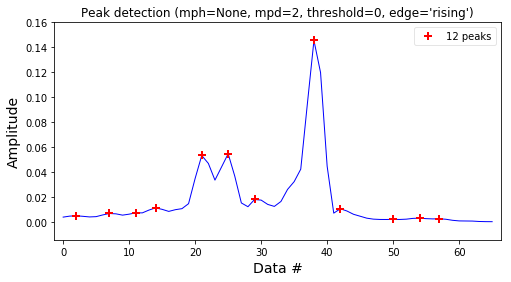

[0.33868093 0.39809863 0.59120618]
[0.05311106 0.05450116 0.14523863]
[0.05311106 0.05450116 0.14523863]
0.14523863448032223
0.5757575757575758
mean: 0.016867086438115124
Maximun:  0.14863833365405338


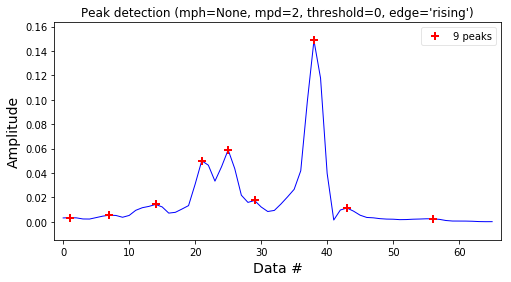

[0.33868093 0.39809863 0.59120618]
[0.05004519 0.05896451 0.14863833]
[0.05004519 0.05896451 0.14863833]
0.14863833365405338
0.3939393939393939
mean: 0.0063546691104961
Maximun:  0.0192457461994371


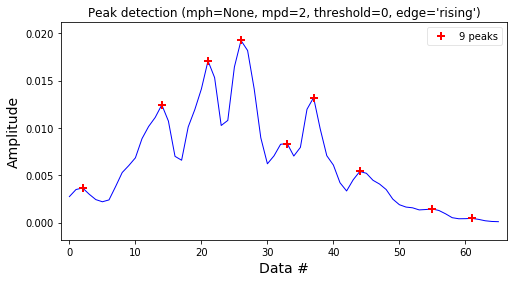

[0.33868093 0.41295306 0.57635175]
[0.01708731 0.01924575 0.01320666]
[0.01320666 0.01708731 0.01924575]
0.0192457461994371
0.4090909090909091
mean: 0.005720786686960992
Maximun:  0.015747416693634223


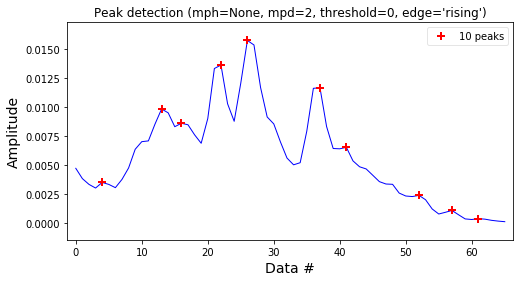

[0.35353535 0.41295306 0.57635175]
[0.01362512 0.01574742 0.01166618]
[0.01166618 0.01362512 0.01574742]
0.015747416693634223
0.19696969696969696
mean: 0.009250389125947152
Maximun:  0.0705516810527356


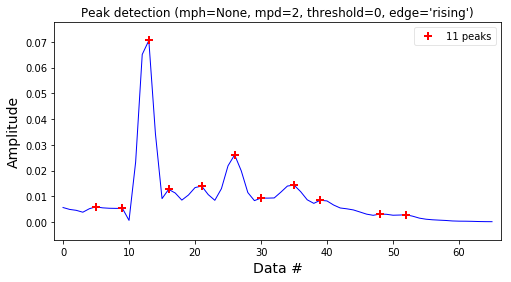

[0.21984551 0.41295306 0.5466429 ]
[0.07055168 0.02608907 0.01433295]
[0.01433295 0.02608907 0.07055168]
0.0705516810527356
0.19696969696969696
mean: 0.013563176759021406
Maximun:  0.11867471604296351


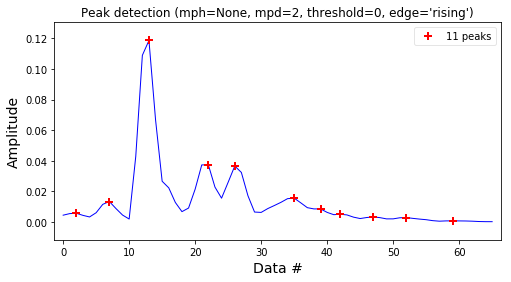

[0.21984551 0.35353535 0.41295306]
[0.11867472 0.03726883 0.03649079]
[0.03649079 0.03726883 0.11867472]
0.11867471604296351
0.19696969696969696
mean: 0.009486717374114252
Maximun:  0.05754818514791902


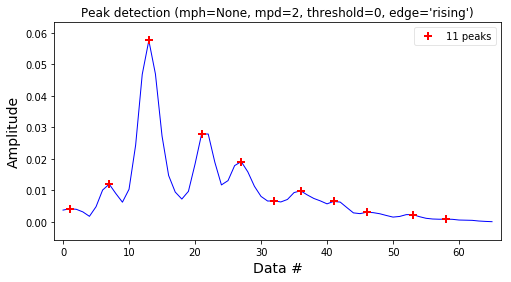

[0.21984551 0.33868093 0.42780749]
[0.05754819 0.02787313 0.01910883]
[0.01910883 0.02787313 0.05754819]
0.05754818514791902
0.42424242424242425
mean: 0.005445341537367818
Maximun:  0.013855045525123441


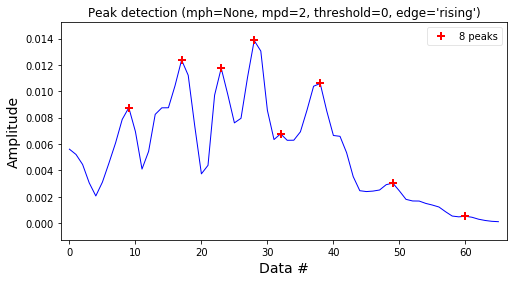

[0.27926322 0.36838978 0.44266191]
[0.01237345 0.01175629 0.01385505]
[0.01175629 0.01237345 0.01385505]
0.013855045525123441
0.24242424242424243
mean: 0.005536523693603899
Maximun:  0.016816080482864627


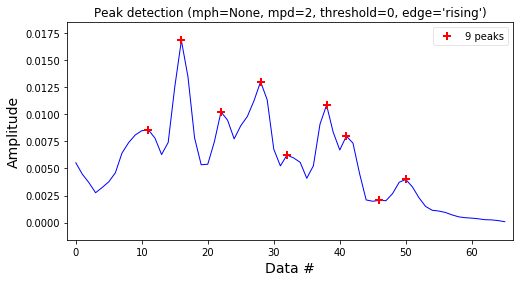

[0.26440879 0.44266191 0.59120618]
[0.01681608 0.01300811 0.01085497]
[0.01085497 0.01300811 0.01681608]
0.016816080482864627
0.24242424242424243
mean: 0.005054979026090377
Maximun:  0.015283988411963347


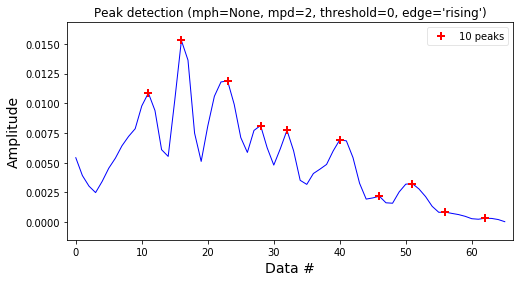

[0.19013666 0.26440879 0.36838978]
[0.01086396 0.01528399 0.01188188]
[0.01086396 0.01188188 0.01528399]
0.015283988411963347
0.3484848484848485
mean: 0.005415200326765854
Maximun:  0.013330161663986569


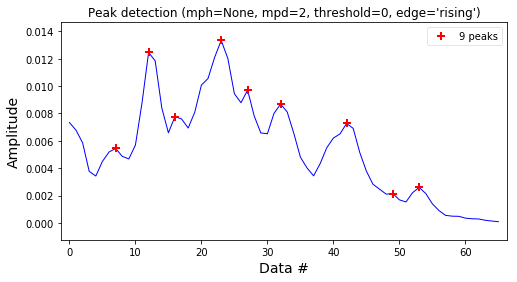

[0.20499109 0.36838978 0.42780749]
[0.01245955 0.01333016 0.00970372]
[0.00970372 0.01245955 0.01333016]
0.013330161663986569
0.4696969696969697
mean: 0.0070898634031961024
Maximun:  0.01929839947672548


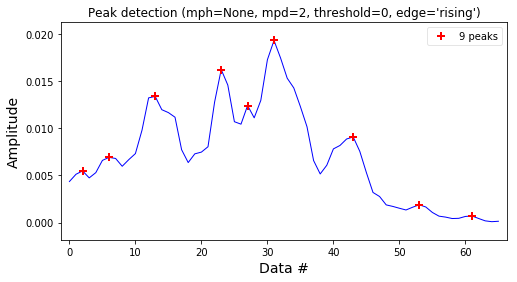

[0.21984551 0.36838978 0.48722519]
[0.01336544 0.01621653 0.0192984 ]
[0.01336544 0.01621653 0.0192984 ]
0.01929839947672548
0.4696969696969697
mean: 0.006774552811417223
Maximun:  0.01864451850757258


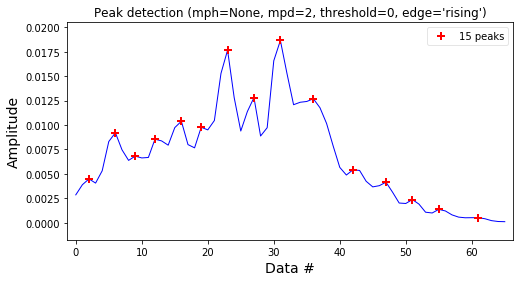

[0.36838978 0.42780749 0.48722519]
[0.0176515  0.01280093 0.01864452]
[0.01280093 0.0176515  0.01864452]
0.01864451850757258
0.42424242424242425
mean: 0.006330229201458816
Maximun:  0.015408789967791894


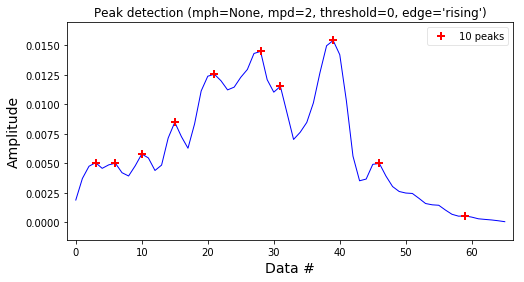

[0.33868093 0.44266191 0.60606061]
[0.01254698 0.01448152 0.01540879]
[0.01254698 0.01448152 0.01540879]
0.015408789967791894
0.5909090909090909
mean: 0.008092701907381575
Maximun:  0.03006850122706333


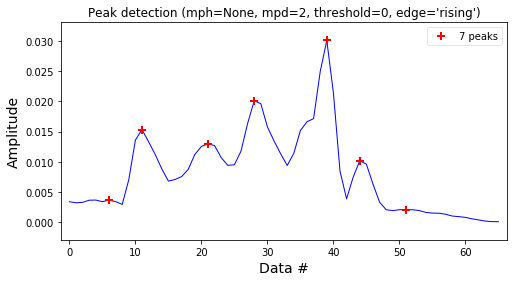

[0.19013666 0.44266191 0.60606061]
[0.0153153  0.02009786 0.0300685 ]
[0.0153153  0.02009786 0.0300685 ]
0.03006850122706333
0.5757575757575758
mean: 0.006966313187972753
Maximun:  0.017927024330105887


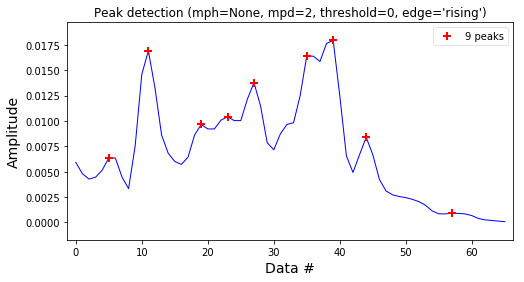

[0.19013666 0.5466429  0.60606061]
[0.01690786 0.01641975 0.01792702]
[0.01641975 0.01690786 0.01792702]
0.017927024330105887
0.6060606060606061
mean: 0.11276435137774218
Maximun:  0.8271136125819267


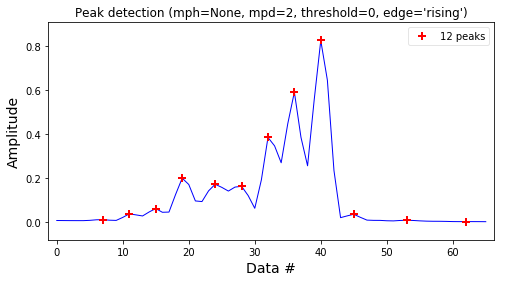

[0.50207962 0.56149733 0.62091503]
[0.38444372 0.59158341 0.82711361]
[0.38444372 0.59158341 0.82711361]
0.8271136125819267
0.6060606060606061
mean: 0.11492322318035278
Maximun:  0.8318441560545562


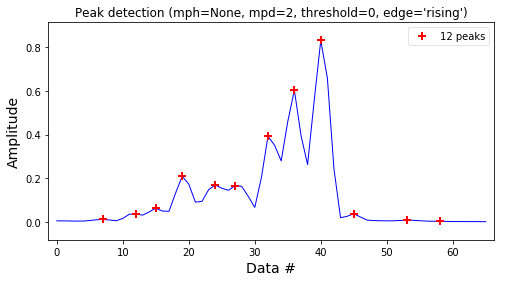

[0.50207962 0.56149733 0.62091503]
[0.39201318 0.60392351 0.83184416]
[0.39201318 0.60392351 0.83184416]
0.8318441560545562
0.5606060606060606
mean: 0.0070819466362776855
Maximun:  0.019993365021095822


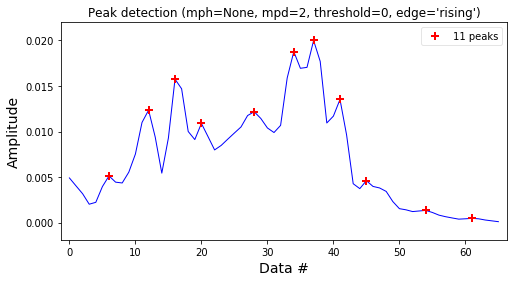

[0.26440879 0.53178847 0.57635175]
[0.01574682 0.01876898 0.01999337]
[0.01574682 0.01876898 0.01999337]
0.019993365021095822
0.5151515151515151
mean: 0.0053547019704213205
Maximun:  0.016514203099364293


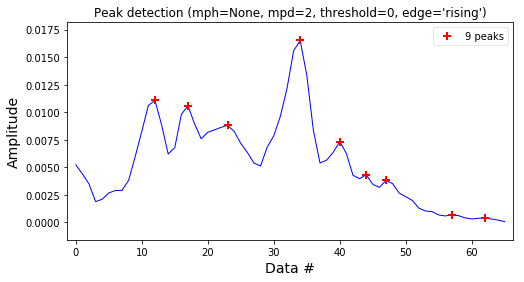

[0.20499109 0.27926322 0.53178847]
[0.01106851 0.01059463 0.0165142 ]
[0.01059463 0.01106851 0.0165142 ]
0.016514203099364293
0.48484848484848486
mean: 0.006342657332609137
Maximun:  0.015941662329024074


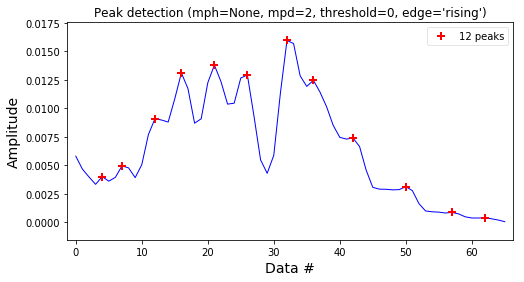

[0.26440879 0.33868093 0.50207962]
[0.01309588 0.01378621 0.01594166]
[0.01309588 0.01378621 0.01594166]
0.015941662329024074
0.5454545454545454
mean: 0.00804250530014424
Maximun:  0.023939785349030414


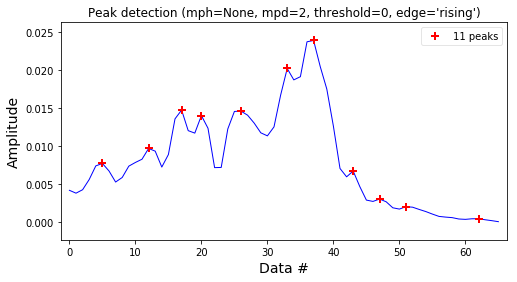

[0.27926322 0.51693405 0.57635175]
[0.01475896 0.02024247 0.02393979]
[0.01475896 0.02024247 0.02393979]
0.023939785349030414
0.5454545454545454
mean: 0.006803588703556568
Maximun:  0.018469040777637263


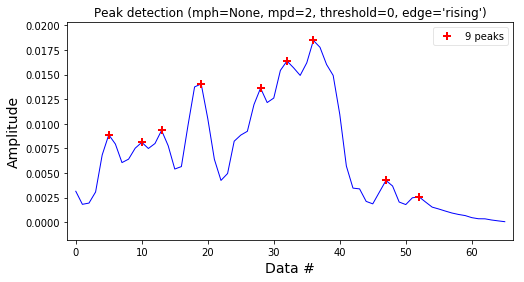

[0.30897207 0.50207962 0.56149733]
[0.0140511  0.01638204 0.01846904]
[0.0140511  0.01638204 0.01846904]
0.018469040777637263
0.4696969696969697
mean: 0.0047797065069814775
Maximun:  0.011847393287197049


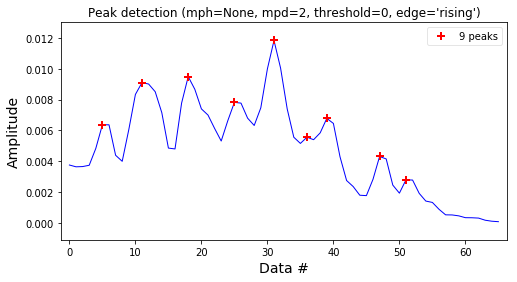

[0.19013666 0.29411765 0.48722519]
[0.00910911 0.00949821 0.01184739]
[0.00910911 0.00949821 0.01184739]
0.011847393287197049
0.30303030303030304
mean: 0.004977033194686693
Maximun:  0.01196360801334753


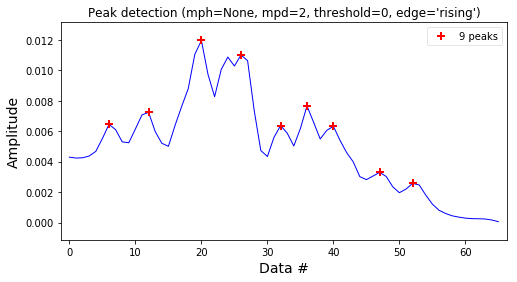

[0.3238265  0.41295306 0.56149733]
[0.01196361 0.01100936 0.00766376]
[0.00766376 0.01100936 0.01196361]
0.01196360801334753
0.5606060606060606
mean: 0.02449796004056195
Maximun:  0.14774056093205584


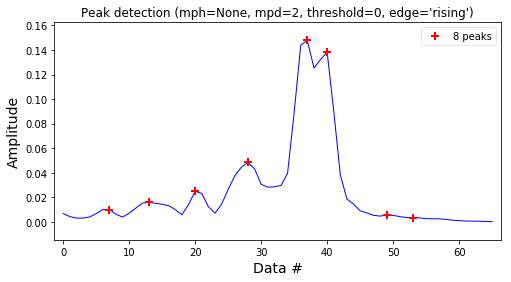

[0.44266191 0.57635175 0.62091503]
[0.04833053 0.14774056 0.13827005]
[0.04833053 0.13827005 0.14774056]
0.14774056093205584
0.5454545454545454
mean: 0.07021269055848513
Maximun:  0.5445877489827247


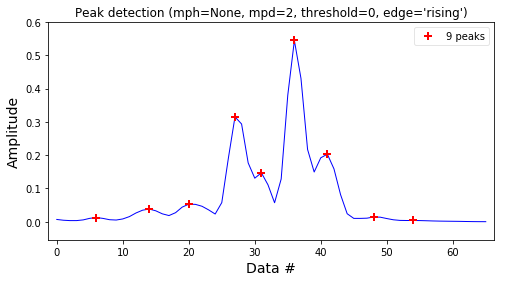

[0.42780749 0.56149733 0.63576946]
[0.31487328 0.54458775 0.20284802]
[0.20284802 0.31487328 0.54458775]
0.5445877489827247
0.5454545454545454
mean: 0.054186193720182504
Maximun:  0.4043967494455989


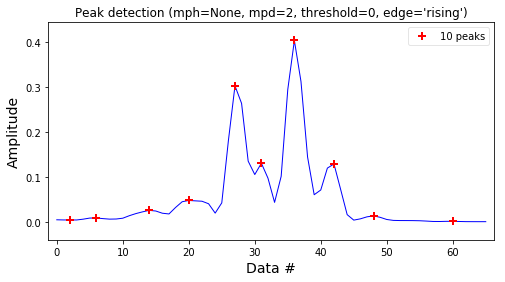

[0.42780749 0.48722519 0.56149733]
[0.30315681 0.13059167 0.40439675]
[0.13059167 0.30315681 0.40439675]
0.4043967494455989
0.5606060606060606
mean: 0.018478711197347744
Maximun:  0.09792869238865361


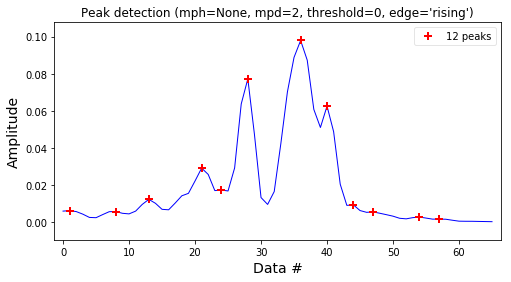

[0.44266191 0.56149733 0.62091503]
[0.0772119  0.09792869 0.06250682]
[0.06250682 0.0772119  0.09792869]
0.09792869238865361
0.5606060606060606
mean: 0.015221249856144013
Maximun:  0.07800613724507222


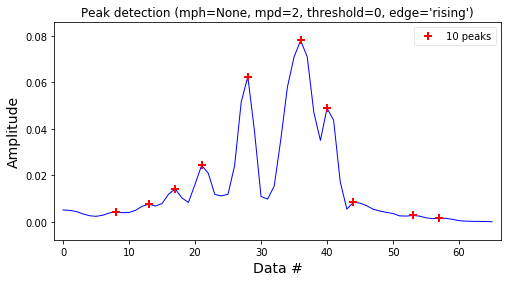

[0.44266191 0.56149733 0.62091503]
[0.06247272 0.07800614 0.04892753]
[0.04892753 0.06247272 0.07800614]
0.07800613724507222
0.5606060606060606
mean: 0.006271267784836267
Maximun:  0.017883735628376966


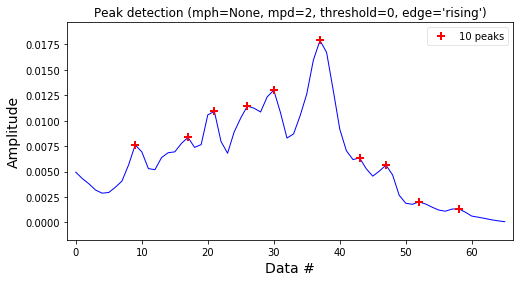

[0.41295306 0.47237077 0.57635175]
[0.01143517 0.01299744 0.01788374]
[0.01143517 0.01299744 0.01788374]
0.017883735628376966
0.3787878787878788
mean: 0.043217790334437615
Maximun:  0.4116783078680146


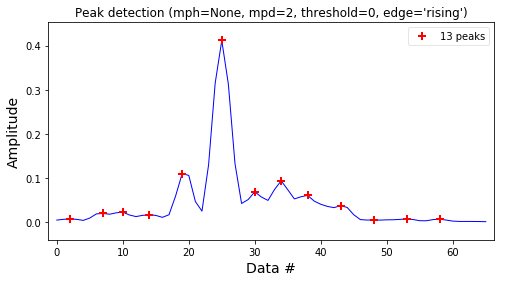

[0.30897207 0.39809863 0.53178847]
[0.10942911 0.41167831 0.09308142]
[0.09308142 0.10942911 0.41167831]
0.4116783078680146
0.36363636363636365
mean: 0.05890434189619324
Maximun:  0.4702604397184892


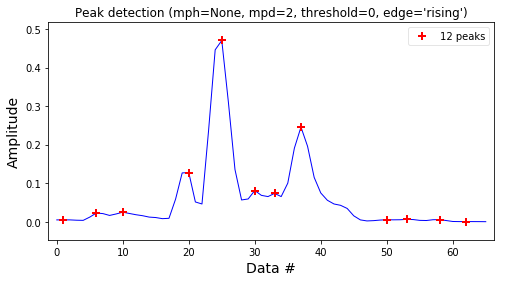

[0.3238265  0.39809863 0.57635175]
[0.12748357 0.47026044 0.245539  ]
[0.12748357 0.245539   0.47026044]
0.4702604397184892
0.5606060606060606
mean: 0.02169413992829451
Maximun:  0.149462344352926


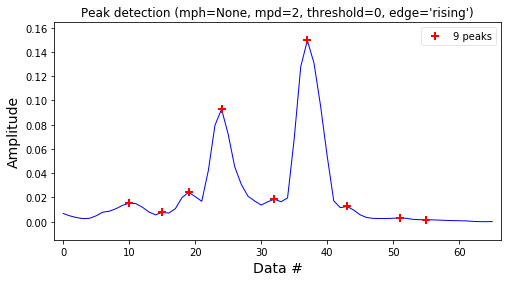

[0.30897207 0.38324421 0.57635175]
[0.02422299 0.0928443  0.14946234]
[0.02422299 0.0928443  0.14946234]
0.149462344352926
0.3787878787878788
mean: 0.0048089530400129326
Maximun:  0.01342820384754819


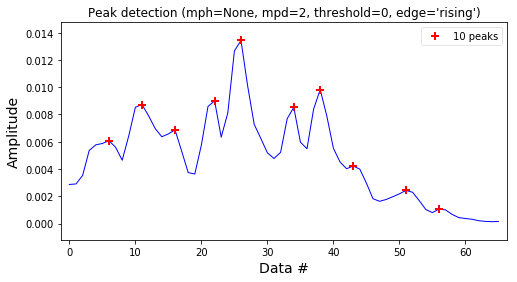

[0.35353535 0.41295306 0.59120618]
[0.00899934 0.0134282  0.00982544]
[0.00899934 0.00982544 0.0134282 ]
0.01342820384754819
0.3333333333333333
mean: 0.004931763163543806
Maximun:  0.01119927266137298


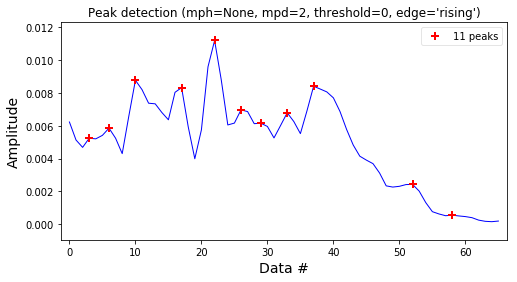

[0.17528223 0.35353535 0.57635175]
[0.00877262 0.01119927 0.00840827]
[0.00840827 0.00877262 0.01119927]
0.01119927266137298
0.3333333333333333
mean: 0.0047462248777515766
Maximun:  0.010415834722843968


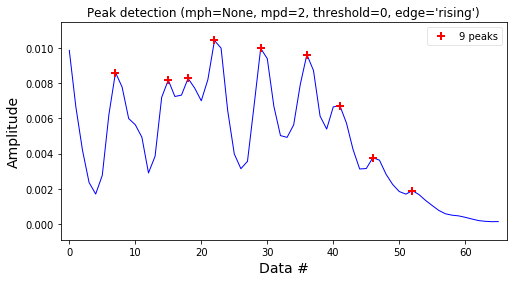

[0.35353535 0.45751634 0.56149733]
[0.01041583 0.00997106 0.00961889]
[0.00961889 0.00997106 0.01041583]
0.010415834722843968


In [166]:
for ini, fini in index_list_of_segment(n_spliting_seg):

#for i in np.arange(0,34,s):
    quake_time, _frequencies, power_spectrum = get_segment_spectrum(signal_seg[ini:fini])
    index_max = np.argmax(power_spectrum) 
    #print(index_max)
    #print(_frequencies[index_max])
    print(feature_calculators.first_location_of_maximum(power_spectrum))
    print('mean:', np.mean(power_spectrum))
    
    #result = power_spectrum
    result = savgol_filter(power_spectrum, 5, 2)

    #value_to_plot.append(np.std(result))
    #value_to_plot.append(sp.stats.kurtosis(result))
    #value_to_plot.append(np.max(result))
    
    
    #plt.plot(_frequencies, power_spectrum/np.max(power_spectrum))
    #plt.plot(_frequencies, power_spectrum)
    #plt.plot(_frequencies[:len(_frequencies)-1], np.diff(result/np.max(result)))
    #plt.plot(_frequencies, result/np.max(result))
    #ind = detect_peaks(np.log(result),mpd=10,mph=-4, show=True)
    print('Maximun: ',max(result))
    #ind = detect_peaks(result/np.max(result),mpd=2, show=True)
    ind = detect_peaks(result,mpd=2, show=True)
    index_sort = np.sort(ind[np.argsort(result[ind])[-3:]])
    print(_frequencies[index_sort]/normalize_frec)
    print(result[index_sort])
    index_sort_1 = ind[np.argsort(result[ind])[-3:]]
    print(result[index_sort_1])
    print(max(result[index_sort_1]))

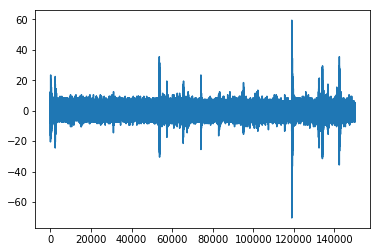

In [102]:
signal_seg['acoustic_data'] -= signal_seg['acoustic_data'].mean() 
plt.plot(signal_seg['acoustic_data'].values)

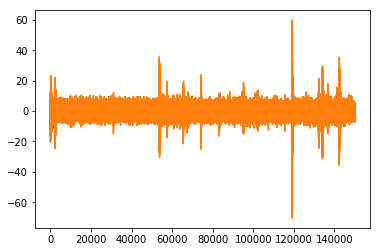

In [148]:

plt.plot(savgol_filter(signal_seg['acoustic_data'][113700:118900].values, 15, 2))

#plt.plot(sp.signal.medfilt(signal_seg['acoustic_data'][118750:118999].values,21))
#plt.plot(signal_seg['acoustic_data'][113700:119000].values)

#plt.plot(sp.signal.medfilt(signal_seg['acoustic_data'][15000:16100].values,11))
plt.plot(signal_seg['acoustic_data'].values)


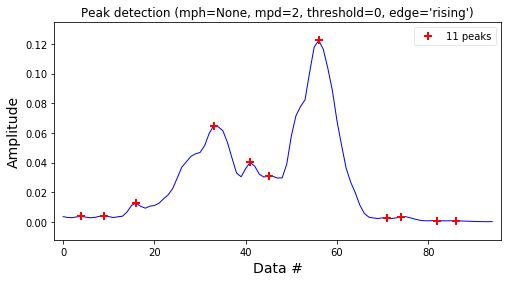

In [149]:
quake_time, _frequencies, power_spectrum = get_segment_spectrum(signal_seg[114700:119000])
result = savgol_filter(power_spectrum, 5, 2)
ind = detect_peaks(result,mpd=2, show=True)

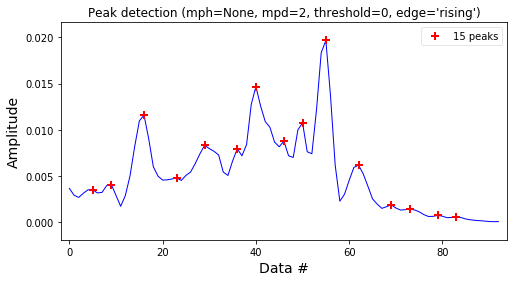

In [150]:
quake_time, _frequencies, power_spectrum = get_segment_spectrum(signal_seg[114700:118900])
result = savgol_filter(power_spectrum, 5, 2)
ind = detect_peaks(result,mpd=2, show=True)

In [1]:
# progress bars
from tqdm import tqdm_notebook as tqdm

lista = []
lista.append(1)
lista.append(2)

print(enumerate(lista))

for i,j in enumerate(tqdm(lista)):
    print(i,j)

0 1
1 2

